#### Install all required libraries
The following code was running on MacBook Pro 2020 with no Nvidia GPU

In [1]:
# !pip install tensorflow
# !pip install numpy
# !pip install opencv-python
# !pip install matplotlib
# # !pip install --upgrade --index-url https://pypi.ngc.nvidia.com nvidia-tensorrt
# !pip install onnxruntime==1.12.0
# !pip install git+https://github.com/onnx/tensorflow-onnx
# !pip install keras2onnx

#### Check list of installed packages

In [2]:
# !pip list

In [3]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imghdr

#### Check data

In [4]:
data_dir = "./data"
image_exts = ['jpg', 'jpeg', 'bmp', 'png']

In [5]:
# wick = os.listdir(os.path.join(data_dir, 'wick'))
# rambo = os.listdir(os.path.join(data_dir, 'rambo')) 
# sad = os.listdir(os.path.join(data_dir, 'sad'))
# happy = os.listdir(os.path.join(data_dir, 'happy')) 

#### The following Cell detect images with wrong extentions. These images could make problems during training the network. 

There is a file created by Mac called .DS_Store. Next cell will check each file and ignore it whenever it sees it.

In [6]:
# Go to the data directory
for image_class in os.listdir(data_dir): 
    if image_class == '.DS_Store':
        continue
    # Enter images directories
    for image in os.listdir(os.path.join(data_dir, image_class)):
        if image == '.DS_Store':
            continue
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

#### Next step is to load data for training

In [7]:
data = tf.keras.utils.image_dataset_from_directory('data')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 252 files belonging to 2 classes.


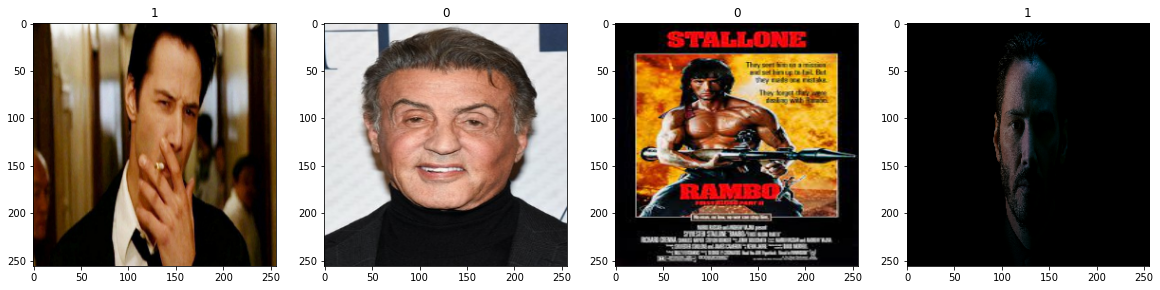

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#### Scale and Split Data

In [9]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()
train_size = int(len(data)*.5)
val_size = int(len(data)*.3)
test_size = int(len(data)*.2)
print("Train size", train_size)
print("Validation", val_size)
print("Test size", test_size)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Train size 4
Validation 2
Test size 1


#### Build deep learning model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras import activations

model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(Activation(activations.relu))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation(activations.relu))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3)))
model.add(BatchNormalization())
model.add(Activation(activations.relu))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation(activations.relu))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3)))
model.add(BatchNormalization())
model.add(Activation(activations.relu))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# model.summary()

#### Training

In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
hist = model.fit(train, epochs=300, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/300
4/4 [==============================] - 9s 2s/step - loss: 1.0170 - accuracy: 0.4609 - val_loss: 0.6933 - val_accuracy: 0.4531
Epoch 2/300
4/4 [==============================] - 8s 2s/step - loss: 0.7063 - accuracy: 0.6406 - val_loss: 0.7025 - val_accuracy: 0.3906
Epoch 3/300
4/4 [==============================] - 8s 2s/step - loss: 0.5507 - accuracy: 0.6797 - val_loss: 0.6843 - val_accuracy: 0.5469
Epoch 4/300
4/4 [==============================] - 8s 2s/step - loss: 0.4475 - accuracy: 0.7812 - val_loss: 0.6775 - val_accuracy: 0.5781
Epoch 5/300
4/4 [==============================] - 8s 2s/step - loss: 0.6022 - accuracy: 0.6797 - val_loss: 0.6851 - val_accuracy: 0.5156
Epoch 6/300
4/4 [==============================] - 7s 2s/step - loss: 0.3988 - accuracy: 0.7812 - val_loss: 0.6904 - val_accuracy: 0.5156
Epoch 7/300
4/4 [==============================] - 8s 2s/step - loss: 0.3347 - accuracy: 0.8516 - val_loss: 0.6868 - val_accuracy: 0.5781
Epoch 8/300
4/4 [=================

#### Plot performance

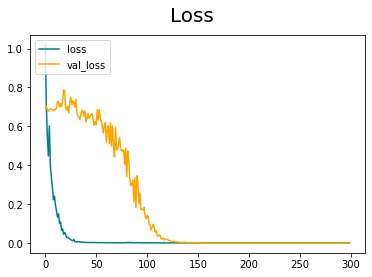

In [12]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

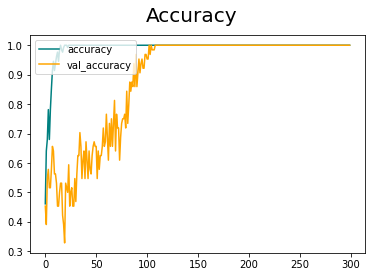

In [13]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#### Evaluation

In [14]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [15]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [16]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 356ms/step


In [17]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


#### Testing

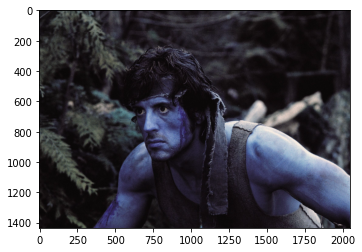

In [24]:
img = cv2.imread('rambo.jpg')
plt.imshow(img)
plt.show()

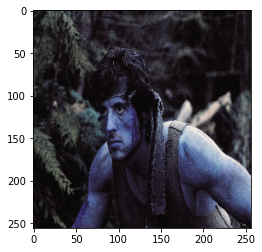

In [25]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [26]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 32ms/step


In [27]:
yhat

array([[0.12687774]], dtype=float32)

In [28]:
if yhat > 0.5: 
    print(f'Predicted class is Wick')
else:
    print(f'Predicted class is Rambo')

Predicted class is Rambo


#### Save the Model

In [29]:
# import tensorrt as trt

# trt.__version__

In [30]:
# from tensorflow.keras.models import load_model
# model.save(os.path.join('models','imageclassifier.h5'))
# new_model = load_model('imageclassifier.h5')
# new_model.predict(np.expand_dims(resize/255, 0))

# Save model in the saved_model format
SAVED_MODEL_DIR="./models/native_saved_model/"
model.save(SAVED_MODEL_DIR)

INFO:tensorflow:Assets written to: ./models/native_saved_model/assets


INFO:tensorflow:Assets written to: ./models/native_saved_model/assets


In [31]:
!python -m tf2onnx.convert --saved-model "./models/native_saved_model" --output model.onnx --opset 11 --verbose


2022-12-24 12:12:15.744740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/seyedalicheraghi/miniconda3/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-12-24 12:12:19,847 - WARNING - tf2onnx.tf_loader: '--tag' not specified for saved_model. Using --tag serve
2022-12-24 12:12:20,408 - INFO - tf2onnx.tf_loader: Signatures found in model: [serving_default].
2022-12-24 12:12:20,408 - WARNING - tf2onnx.tf_loader: '--signature_def' not specified, using first signature: serving_default
2022-12-24 12:12:20,408 - INFO - tf2onnx.tf_loader: 